# Morph average PILRs into mean shape

In [1]:
!date

Tue Nov 14 19:25:17 PST 2023


In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

from cellpack_analysis.utilities import common
from pathlib import Path

from cvapipe_analysis.tools import io, general, controller, shapespace
from aicscytoparam import cytoparam

/allen/aics/animated-cell/Saurabh/Softwares/miniconda3/envs/cellpack_analysis/lib/python3.9/site-packages/pydantic/_migration.py:281: UserWarning: `pydantic.error_wrappers:ValidationError` has been moved to `pydantic:ValidationError`.
  warnings.warn(f'`{import_path}` has been moved to `{new_location}`.')
/allen/aics/animated-cell/Saurabh/Softwares/miniconda3/envs/cellpack_analysis/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.17) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


### Initialize CVAPIPE

In [3]:
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/datasets/variance")
control = controller.Controller(general.load_config_file(path_config))
print(control.get_staging())

/allen/aics/assay-dev/MicroscopyOtherData/Viana/datasets/variance


### Compute voxelization of mean shape

In [4]:
domain, domain_nuc, domain_mem, coords_param = common.get_mean_shape_as_image(control)

### Load computed average PILRs

In [5]:
STRUCTURE_ID = "SLC25A17"
STRUCTURE_NAME = "peroxisome"
FOLDER_ID = "RV"

In [11]:
FOLDER_ID

'RV'

In [6]:
base_folder = Path(f"/allen/aics/animated-cell/Saurabh/cellpack-analysis/results/{STRUCTURE_ID}/{FOLDER_ID}/")

In [7]:
with open(base_folder / "avg_PILR.json", "r") as f:
    avg_pilr = json.load(f)

avg_pilr = {
    k: np.expand_dims(np.array(v), 0)
    for k, v in avg_pilr.items()
}
print(avg_pilr.keys())

dict_keys(['SLC25A17', 'random', 'nucleus_moderate', 'membrane_moderate'])


### Morph average PILRs

In [8]:
figdir = base_folder / "morphed_average_pilrs"
figdir.mkdir(exist_ok=True)

In [9]:
plt.rcdefaults()

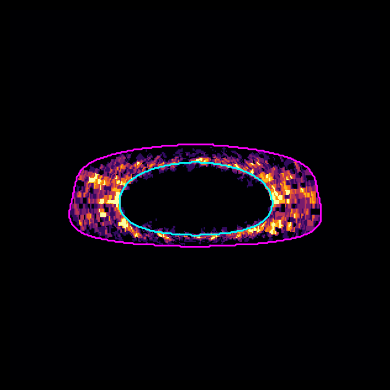

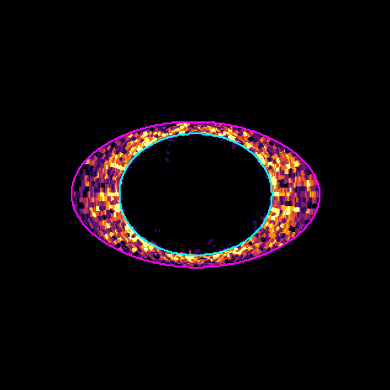

In [12]:
for ch, pilr in avg_pilr.items():
    morphed = cytoparam.morph_representation_on_shape(
        img=domain,
        param_img_coords=coords_param,
        representation=pilr,
    )
    data = np.stack([domain_nuc, domain_mem, morphed], axis=0)
    mode = {"nuc":"center_nuc","mem":"center_nuc","gfp":"center_nuc"}
    if "nucleus" in ch:
        vmin = np.percentile(pilr, 1)
        vmax = np.percentile(pilr, 80)
    else:
        continue
        vmin = 0
        vmax = np.percentile(pilr, 99)
    projector = common.Projector(data, mask_on=True, box_size=300, force_fit=True)
    projector.set_vmin_vmax_gfp_values(vmin, vmax)
    projector.set_panel_size(4)
    for proj, dim in enumerate(["y", "z"]):
        fig, ax = plt.subplots(1,1,figsize=(4,4), facecolor="black")
        projector.set_projection_mode(ax=dim, mode=mode)
        projector.compute()
        contour = projector.get_proj_contours()
        projector.view(alias="gfp", ax=ax)
        for alias_cont, alias_color in zip(["nuc", "mem"], ["cyan", "magenta"]):
            [ax.plot(c[:,1], c[:,0], lw=1, color=alias_color) for c in contour[alias_cont]]
            [ax.plot(c[:,1], c[:,0], lw=1, color=alias_color) for c in contour[alias_cont]]
        # ax.set_title(f"{ch} {dim}")
        ax.axis("off")
        plt.tight_layout()
        fig.savefig(figdir / f"{ch}_{dim}.png")
        plt.show()
        # break
    # break